<a href="https://colab.research.google.com/github/azizamirsaidova/aws_disaster_response_hackathon/blob/main/Loss_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tornado Analysis 


## Finding the Vulnurability Score of the States

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
import plotly.graph_objects as go 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
df=pd.read_csv('Tornadoes_SPC_1950to2015.csv').rename({'yr':'Year','fat':'Fatalities','loss':'Property_Losses','inj':'Injuries','mag':'EF','closs':'Crop_Loss','st':'State'},axis=1)
df.head()

,om,Year,mo,dy,date,time,tz,State,stf,stn,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,fc
0,1,1950,1,3,1/3/1950,11:00:00,3,MO,29,1,3,3,0,6.0,0.0,38.77,-90.22,38.83,-90.03,9.5,150,0
1,2,1950,1,3,1/3/1950,11:55:00,3,IL,17,2,3,3,0,5.0,0.0,39.10,-89.30,39.12,-89.23,3.6,130,0
2,3,1950,1,3,1/3/1950,16:00:00,3,OH,39,1,1,1,0,4.0,0.0,40.88,-84.58,0.00,0.00,0.1,10,0
3,4,1950,1,13,1/13/1950,5:25:00,3,AR,5,1,3,1,1,3.0,0.0,34.40,-94.37,0.00,0.00,0.6,17,0
4,5,1950,1,25,1/25/1950,19:30:00,3,MO,29,2,2,5,0,5.0,0.0,37.60,-90.68,37.63,-90.65,2.3,300,0


In [2]:
df.describe()

,om,Year,mo,dy,tz,stf,stn,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,fc
count,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000
mean,41119.375753,1987.970057,5.972436,15.876368,3.001098,29.419919,26.476228,0.796154,1.561300,0.096866,2.159312,0.002134,37.155205,-92.961133,20.956247,-51.902893,3.480720,98.454603,0.030991
std,130865.993631,17.787883,2.388809,8.737193,0.077379,15.018850,32.672650,0.912341,19.177704,1.546215,20.284680,0.122182,5.123449,8.719121,18.890353,46.322703,8.519328,195.726277,0.173295
min,1.000000,1950.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.130000,-163.530000,0.000000,-163.530000,0.000000,0.000000,0.000000
25%,248.000000,1974.000000,4.000000,8.000000,3.000000,18.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.240000,-98.600000,0.000000,-94.250000,0.100000,13.000000,0.000000
50%,509.000000,1991.000000,6.000000,16.000000,3.000000,29.000000,15.000000,1.000000,0.000000,0.000000,0.100000,0.000000,37.085000,-93.950000,31.200000,-81.765000,0.600000,40.000000,0.000000
75%,845.000000,2003.000000,7.000000,24.000000,3.000000,45.000000,35.000000,1.000000,0.000000,0.000000,4.000000,0.000000,40.970000,-86.870000,38.150000,0.000000,3.000000,100.000000,0.000000
max,613494.000000,2015.000000,12.000000,31.000000,9.000000,72.000000,232.000000,5.000000,1740.000000,158.000000,2800.100000,23.520000,61.020000,-64.900000,61.020000,0.000000,234.700000,4576.000000,1.000000


In [3]:
df.isnull().sum()

om                 0
Year               0
mo                 0
dy                 0
date               0
time               0
tz                 0
State              0
stf                0
stn                0
EF                 0
Injuries           0
Fatalities         0
Property_Losses    0
Crop_Loss          0
slat               0
slon               0
elat               0
elon               0
len                0
wid                0
fc                 0
dtype: int64

In [4]:
df=df.copy()
df=df.drop(['stn','om','fc','tz','stf'],axis=1)
df['time']=pd.to_datetime(df['time'])
df['hour']=df['time'].apply(lambda x:x.hour)
df['minute']=df['time'].apply(lambda x:x.minute)
df=df.drop('time',axis=1)
df.head()

,Year,mo,dy,date,State,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,hour,minute
0,1950,1,3,1/3/1950,MO,3,3,0,6.0,0.0,38.77,-90.22,38.83,-90.03,9.5,150,11,0
1,1950,1,3,1/3/1950,IL,3,3,0,5.0,0.0,39.10,-89.30,39.12,-89.23,3.6,130,11,55
2,1950,1,3,1/3/1950,OH,1,1,0,4.0,0.0,40.88,-84.58,0.00,0.00,0.1,10,16,0
3,1950,1,13,1/13/1950,AR,3,1,1,3.0,0.0,34.40,-94.37,0.00,0.00,0.6,17,5,25
4,1950,1,25,1/25/1950,MO,2,5,0,5.0,0.0,37.60,-90.68,37.63,-90.65,2.3,300,19,30


In [5]:
# for column in df.columns:
#     missing_cnt = df[column][df[column] == 0].count()
#     print('Zero/Unknown Values in column {col} = '.format(col = column) , missing_cnt )

In [6]:
df.loc[df['Year']<1996,['EF','Property_Losses']].head()

,EF,Property_Losses
0,3,6.0
1,3,5.0
2,1,4.0
3,3,3.0
4,2,5.0


In [7]:
df.loc[df['Year']>=1996,['EF','Property_Losses']].head()

,EF,Property_Losses
35431,0,0.04
35432,0,0.03
35433,0,0.00
35434,1,1.20
35435,0,0.10


In [8]:
df.loc[df['Year']<1996].groupby('EF')['Property_Losses'].agg([np.mean,np.max,np.std])

,mean,amax,std
EF,,,
0,1.230739,7.0,1.644207
1,3.216340,8.0,1.713685
2,4.015239,8.0,1.607244
3,4.749320,8.0,1.639328
4,5.480638,8.0,1.774750
5,5.822222,8.0,2.269250


In [9]:
df.loc[df['Year']>=1996].groupby('EF')['Property_Losses'].agg([np.mean,np.max,np.std])

,mean,amax,std
EF,,,
0,0.022021,30.0,0.345901
1,0.613716,750.0,13.243392
2,2.509558,400.0,13.900840
3,11.810541,500.0,32.949188
4,61.657143,2450.0,239.814954
5,553.441429,2800.1,891.524425


In [10]:
def LossApprox(cols):
    Loss=cols[0]
    EF=cols[1]
    Year=cols[2]
    if Year>1995:
        if Loss<0.00005:
            Loss=1
        elif Loss>=0.00005 and Loss<0.0005:
            Loss=2
        elif Loss>=0.0005 and Loss<0.005:
            Loss=3
        elif Loss>=0.005 and Loss<0.05:
            Loss=4
        elif Loss>=0.05 and Loss<0.5:
            Loss=5
        elif Loss>=0.5 and Loss<5: 
            Loss=6
        elif  Loss>=5 and Loss<50: 
            Loss=7
        elif Loss>=50 and Loss<500: 
            Loss=8
        elif Loss>=500 and Loss<5000: 
            Loss=9
    if Loss==0:
        if EF==0:
            Loss=1
        elif EF==1:
            Loss=3
        elif EF==2:
            Loss=4
        elif EF==3:
            Loss=5
        elif EF==4:
            Loss=6
        elif EF==5:
            Loss=7
    return int(Loss)
df['Property_Losses'] = df[['Property_Losses', 'EF','Year']].apply(LossApprox, axis=1)
print('Number of Missing Property Losses Values:')
print(df.loc[df['Property_Losses']==0,['EF','Year','Property_Losses']].head(10))
print('Property Losses after data processing:')
df.loc[:,['EF','Year','Property_Losses']].head()

Number of Missing Property Losses Values:
Empty DataFrame
Columns: [EF, Year, Property_Losses]
Index: []
Property Losses after data processing:


,EF,Year,Property_Losses
0,3,1950,6
1,3,1950,5
2,1,1950,4
3,3,1950,3
4,2,1950,5


In [11]:
df.loc[df['Year']<2005].groupby('EF')['Crop_Loss'].agg([np.mean,np.max,np.std])

,mean,amax,std
EF,,,
0,0.000000,0.0,0.000000
1,0.000000,0.0,0.000000
2,0.000051,0.4,0.004531
3,0.000000,0.0,0.000000
4,0.000000,0.0,0.000000
5,0.000000,0.0,0.000000


In [12]:
df.loc[df['Year']>2000].groupby('EF')['Crop_Loss'].agg([np.mean,np.max,np.std])

,mean,amax,std
EF,,,
0,0.000621,1.00,0.013499
1,0.004097,3.00,0.056363
2,0.024889,13.00,0.354368
3,0.057703,3.50,0.302729
4,0.402340,23.52,2.614833
5,0.025556,0.23,0.076667


In [13]:
def croplossapprox(cols):
    closs=cols[0]
    EF=cols[1]
    Year=cols[2]
    closs=closs*10**6
    if Year>1999:
        if closs<50:
            closs=1
        elif closs>=50 and closs<500:
            closs=2
        elif closs>=500 and closs<5000:
            closs=3
        elif closs>=5000 and closs<50000:
            closs=4
        elif closs>=50000 and closs<500000:
            closs=5
        elif closs>=500000 and closs<5000000:
            closs=6
        elif closs>=5000000 and closs<50000000:
            closs=7
    if closs==0:
        if EF==0:
            closs=3
        elif EF==1:
            closs=4
        elif EF==2:
            closs=4
        elif EF==3:
            closs=5
        elif EF==4:
            closs=6
        elif EF==5:
            closs=4
    return int(closs)
df['Crop_Loss'] = df[['Crop_Loss', 'EF','Year']].apply(croplossapprox, axis=1)
print('Number of Missing Crop Loss Values:')
print(df.loc[df['Crop_Loss']==0,['EF','Year','Crop_Loss']].head(10))
print('Property Losses after data processing:')
df.loc[:,['EF','Year','Crop_Loss']].head()

Number of Missing Crop Loss Values:
Empty DataFrame
Columns: [EF, Year, Crop_Loss]
Index: []
Property Losses after data processing:


,EF,Year,Crop_Loss
0,3,1950,5
1,3,1950,5
2,1,1950,4
3,3,1950,5
4,2,1950,4


In [14]:
df.describe()

,Year,mo,dy,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,hour,minute
count,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000
mean,1987.970057,5.972436,15.876368,0.796154,1.561300,0.096866,3.046079,2.832984,37.155205,-92.961133,20.956247,-51.902893,3.480720,98.454603,15.149050,25.350035
std,17.787883,2.388809,8.737193,0.912341,19.177704,1.546215,1.797828,1.355259,5.123449,8.719121,18.890353,46.322703,8.519328,195.726277,4.897992,17.714850
min,1950.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,18.130000,-163.530000,0.000000,-163.530000,0.000000,0.000000,0.000000,0.000000
25%,1974.000000,4.000000,8.000000,0.000000,0.000000,0.000000,1.000000,1.000000,33.240000,-98.600000,0.000000,-94.250000,0.100000,13.000000,13.000000,10.000000
50%,1991.000000,6.000000,16.000000,1.000000,0.000000,0.000000,3.000000,3.000000,37.085000,-93.950000,31.200000,-81.765000,0.600000,40.000000,16.000000,26.000000
75%,2003.000000,7.000000,24.000000,1.000000,0.000000,0.000000,5.000000,4.000000,40.970000,-86.870000,38.150000,0.000000,3.000000,100.000000,18.000000,40.000000
max,2015.000000,12.000000,31.000000,5.000000,1740.000000,158.000000,9.000000,7.000000,61.020000,-64.900000,61.020000,0.000000,234.700000,4576.000000,23.000000,59.000000


In [15]:
#Function to calculate no2 individual pollutant index(ni)
def calculate_ni(no2):
    ni=0
    if(no2<=40):
     ni= 1
    elif(no2>40 and no2<=80):
     ni= 2
    elif(no2>80 and no2<=120):
     ni= 3
    else:
     ni= 4
    return ni
df['death_score']=df['Fatalities'].apply(calculate_ni)
df.head()

,Year,mo,dy,date,State,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,hour,minute,death_score
0,1950,1,3,1/3/1950,MO,3,3,0,6,5,38.77,-90.22,38.83,-90.03,9.5,150,11,0,1
1,1950,1,3,1/3/1950,IL,3,3,0,5,5,39.10,-89.30,39.12,-89.23,3.6,130,11,55,1
2,1950,1,3,1/3/1950,OH,1,1,0,4,4,40.88,-84.58,0.00,0.00,0.1,10,16,0,1
3,1950,1,13,1/13/1950,AR,3,1,1,3,5,34.40,-94.37,0.00,0.00,0.6,17,5,25,1
4,1950,1,25,1/25/1950,MO,2,5,0,5,4,37.60,-90.68,37.63,-90.65,2.3,300,19,30,1


In [16]:
#Function to calculate no2 individual pollutant index(ni)
def calculate_ni(no2):
    ni=0
    if(no2<=360):
     ni= 1
    elif(no2>360 and no2<=720):
     ni= 2
    elif(no2>720 and no2<=1080):
     ni= 3
    elif(no2>1080 and no2<=1440):
     ni= 4
    else:
     ni= 5
    return ni
df['Injury_Score']=df['Injuries'].apply(calculate_ni)


In [17]:
df.describe()

,Year,mo,dy,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,hour,minute,death_score,Injury_Score
count,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000,60114.000000
mean,1987.970057,5.972436,15.876368,0.796154,1.561300,0.096866,3.046079,2.832984,37.155205,-92.961133,20.956247,-51.902893,3.480720,98.454603,15.149050,25.350035,1.000299,1.000682
std,17.787883,2.388809,8.737193,0.912341,19.177704,1.546215,1.797828,1.355259,5.123449,8.719121,18.890353,46.322703,8.519328,195.726277,4.897992,17.714850,0.022338,0.038472
min,1950.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,18.130000,-163.530000,0.000000,-163.530000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1974.000000,4.000000,8.000000,0.000000,0.000000,0.000000,1.000000,1.000000,33.240000,-98.600000,0.000000,-94.250000,0.100000,13.000000,13.000000,10.000000,1.000000,1.000000
50%,1991.000000,6.000000,16.000000,1.000000,0.000000,0.000000,3.000000,3.000000,37.085000,-93.950000,31.200000,-81.765000,0.600000,40.000000,16.000000,26.000000,1.000000,1.000000
75%,2003.000000,7.000000,24.000000,1.000000,0.000000,0.000000,5.000000,4.000000,40.970000,-86.870000,38.150000,0.000000,3.000000,100.000000,18.000000,40.000000,1.000000,1.000000
max,2015.000000,12.000000,31.000000,5.000000,1740.000000,158.000000,9.000000,7.000000,61.020000,-64.900000,61.020000,0.000000,234.700000,4576.000000,23.000000,59.000000,4.000000,5.000000


In [18]:
df.columns

Index(['Year', 'mo', 'dy', 'date', 'State', 'EF', 'Injuries', 'Fatalities',
       'Property_Losses', 'Crop_Loss', 'slat', 'slon', 'elat', 'elon', 'len',
       'wid', 'hour', 'minute', 'death_score', 'Injury_Score'],
      dtype='object')

In [19]:
from sklearn.preprocessing import StandardScaler
cols_to_norm = ['death_score','Injury_Score','Crop_Loss','Property_Losses']
df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])


In [20]:
#Function to calculate no2 individual pollutant index(ni)
def calculate_ni(no2):
    ni=0
    if(no2<=0.25):
     ni= 1
    elif(no2>0.25 and no2<=0.50):
     ni= 2
    elif(no2>0.50 and no2<=0.75):
     ni= 3
    else:
     ni= 4
    return ni
df['Injury_Score']=df['Injury_Score'].apply(calculate_ni)
df['death_score']=df['death_score'].apply(calculate_ni)
df['Crop_Loss']=df['Crop_Loss'].apply(calculate_ni)
df['Property_Losses']=df['Property_Losses'].apply(calculate_ni)



In [21]:
df['loss_score']=2*(df['death_score'])+ 1.5*(df['Injury_Score'])+df['Property_Losses']+0.5*(df['Crop_Loss'])

In [22]:
def calculate_ni(no2):
    ni=0
    if(no2<=5):
     ni= 1
    elif(no2>5 and no2<=10):
     ni= 2
    elif(no2>10 and no2<=15):
     ni= 3
    else:
     ni= 4
    return ni
df['loss_score']=df['loss_score'].apply(calculate_ni)

In [23]:
df['loss_score'].tail()

60109    1
60110    2
60111    2
60112    2
60113    2
Name: loss_score, dtype: int64

In [24]:
df['loss_score'].value_counts()

2    36174
1    23910
3       18
4       12
Name: loss_score, dtype: int64

In [25]:
fig = px.pie(df, values='loss_score', names='loss_score')
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

In [26]:
df

,Year,mo,dy,date,State,EF,Injuries,Fatalities,Property_Losses,Crop_Loss,slat,slon,elat,elon,len,wid,hour,minute,death_score,Injury_Score,loss_score
0,1950,1,3,1/3/1950,MO,3,3,0,4,4,38.77,-90.22,38.83,-90.03,9.50,150,11,0,1,1,2
1,1950,1,3,1/3/1950,IL,3,3,0,4,4,39.10,-89.30,39.12,-89.23,3.60,130,11,55,1,1,2
2,1950,1,3,1/3/1950,OH,1,1,0,3,4,40.88,-84.58,0.00,0.00,0.10,10,16,0,1,1,2
3,1950,1,13,1/13/1950,AR,3,1,1,1,4,34.40,-94.37,0.00,0.00,0.60,17,5,25,1,1,2
4,1950,1,25,1/25/1950,MO,2,5,0,4,4,37.60,-90.68,37.63,-90.65,2.30,300,19,30,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60109,2015,12,28,12/28/2015,LA,1,0,0,1,1,30.08,-90.54,30.08,-90.53,0.60,150,3,20,1,1,1
60110,2015,12,28,12/28/2015,AR,2,0,0,4,1,34.70,-90.92,34.78,-90.90,5.75,40,4,46,1,1,2
60111,2015,12,28,12/28/2015,MS,1,0,0,4,1,31.54,-89.53,31.61,-89.49,5.59,100,5,43,1,1,2
60112,2015,12,28,12/28/2015,FL,1,0,0,3,1,30.76,-87.24,30.77,-87.23,0.78,75,8,30,1,1,2


In [27]:
df[['State','loss_score']].value_counts()

State  loss_score
TX     2             4602
       1             3878
KS     1             2350
OK     2             2096
FL     2             1932
                     ... 
SC     3                1
FL     3                1
CT     3                1
DC     2                1
IN     3                1
Length: 125, dtype: int64

In [28]:
df_agg = df.groupby(['State']).agg({'loss_score':['sum']}).reset_index()
df_agg

,State,loss_score
,,sum
0,AK,4
1,AL,3542
2,AR,2879
3,AZ,342
4,CA,642
5,CO,2780
6,CT,170
7,DC,2
8,DE,101


In [29]:
df_agg = pd.DataFrame({'state':df_agg['State'], 'loss_score_total': df_agg['loss_score']['sum']})

In [30]:
df_agg

,state,loss_score_total
0,AK,4
1,AL,3542
2,AR,2879
3,AZ,342
4,CA,642
5,CO,2780
6,CT,170
7,DC,2
8,DE,101
9,FL,5167


In [37]:
fig1 = px.bar(df_agg.sort_values(by = ['loss_score_total']), x='state', y='loss_score_total',
             hover_data=['state', 'loss_score_total'], color='state',
             height=400)
#labels={'pop':'population of Canada'}
fig1.show()

## Anlazying Severity of Tornado

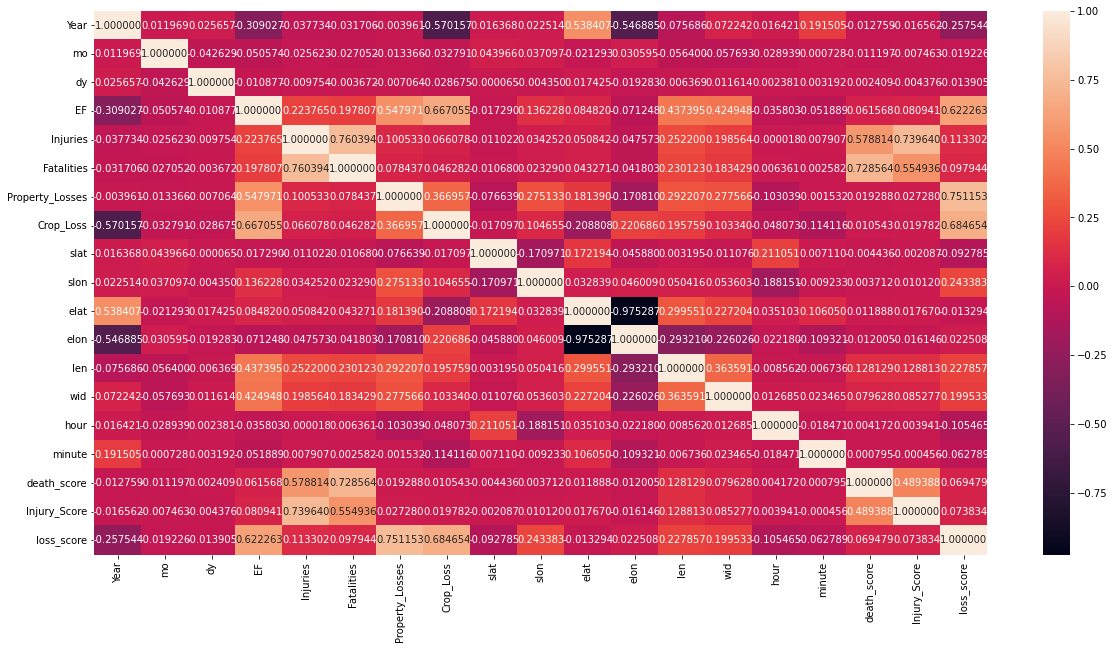

In [38]:
corr = df.corr()
corr = (corr)
a4_dims=(20,10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(corr,annot=True,fmt='f',xticklabels=corr.columns.values,yticklabels=corr.columns.values)

In [40]:
fig = px.pie(df, values='EF', names='EF', title='Tornado Magnitude')
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



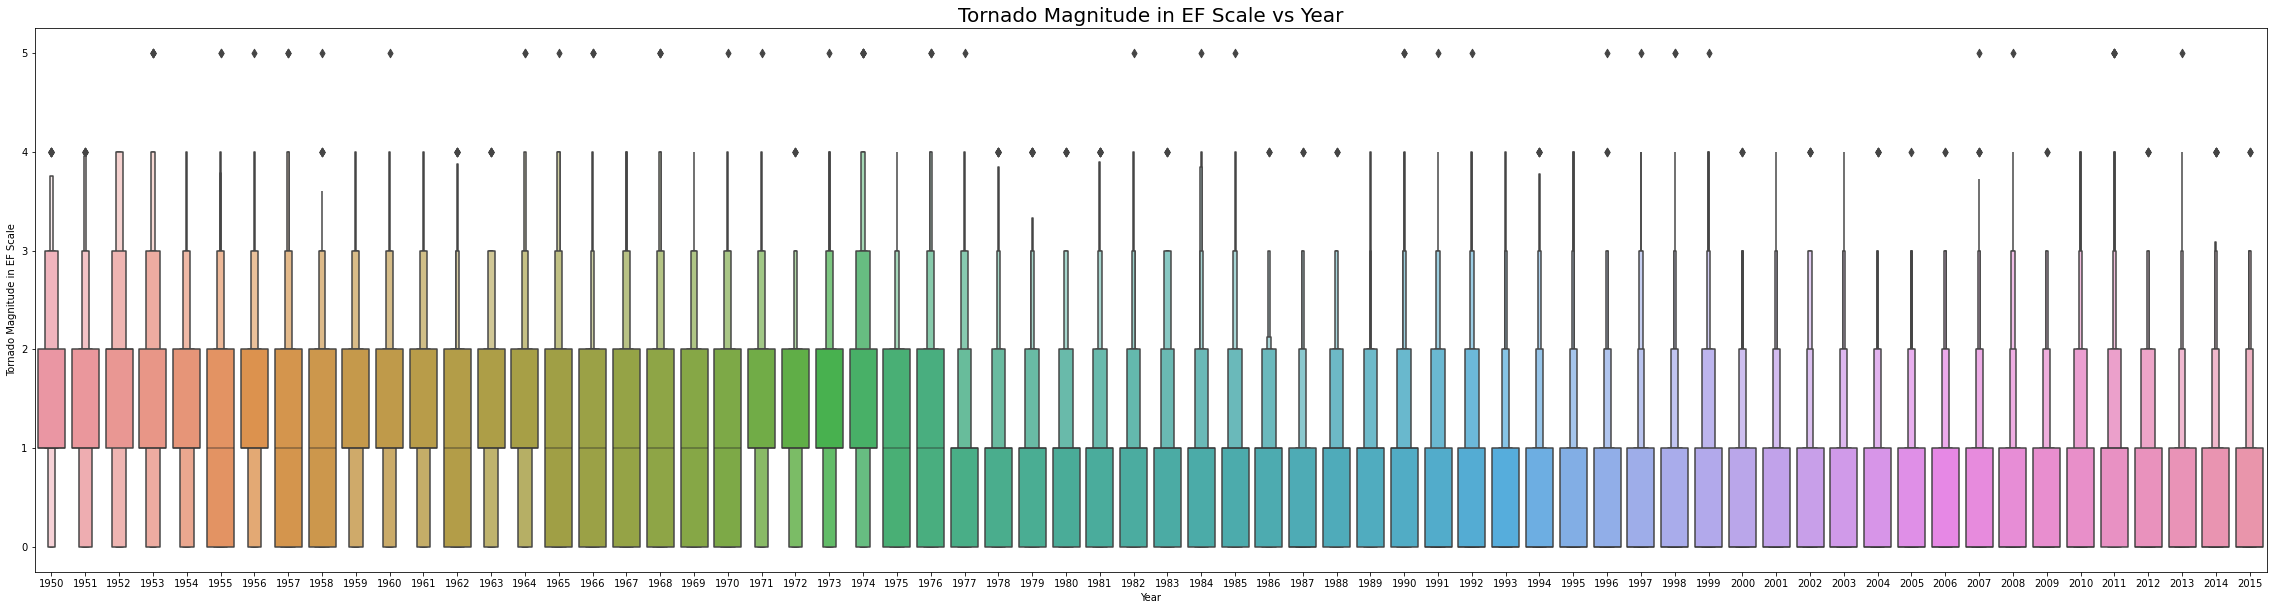

In [41]:
plt.rcParams['figure.figsize']=(40, 10)
plt.style.use('seaborn-dark-palette')
sns.boxenplot(df['Year'],df['EF'])
plt.xlabel('Year')
plt.ylabel('Tornado Magnitude in Scale')
plt.title('Tornado Magnitude in Scale vs Year',fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



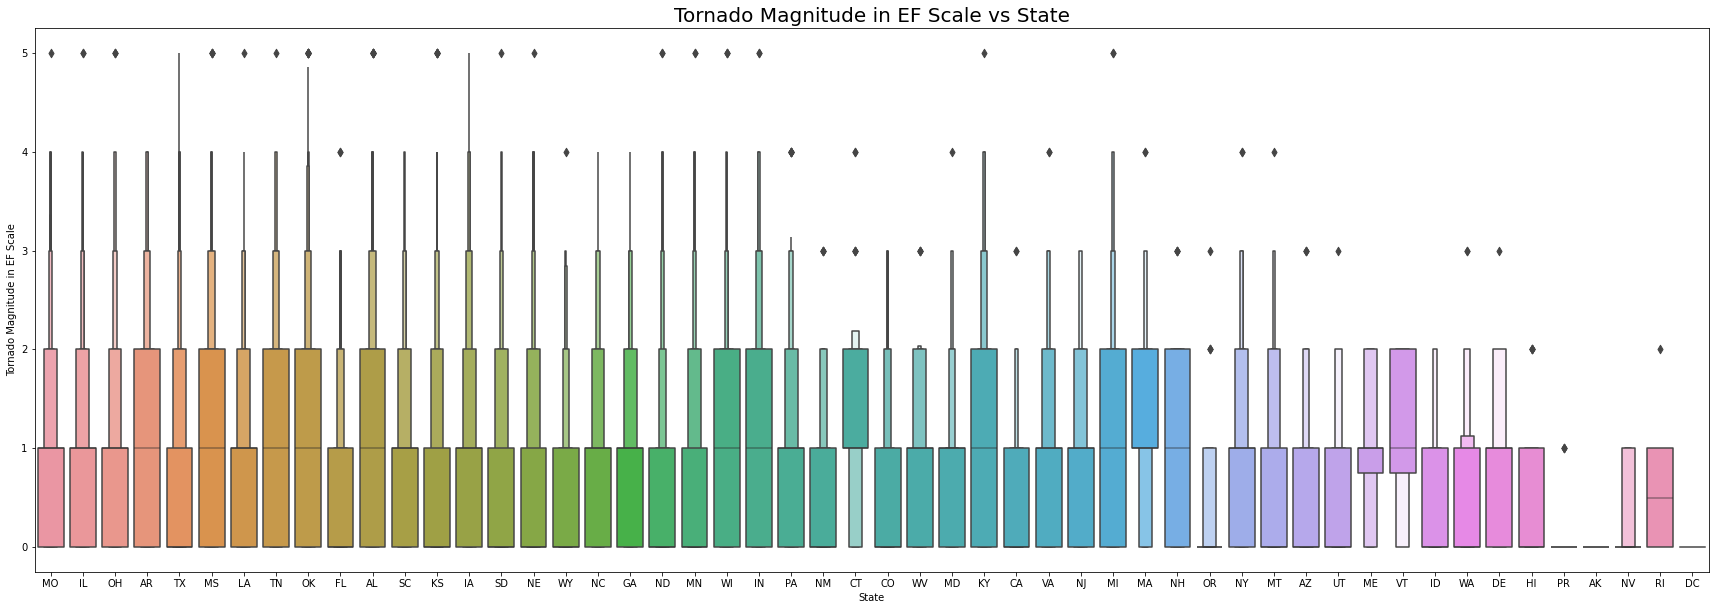

In [42]:
plt.rcParams['figure.figsize']=(30, 10)
plt.style.use('seaborn-dark-palette')
sns.boxenplot(df['State'],df['EF'])
plt.title('Tornado Magnitude in Scale vs State',fontsize=20)
plt.xlabel('State')
plt.ylabel('Tornado Magnitude in Scale')
plt.show()

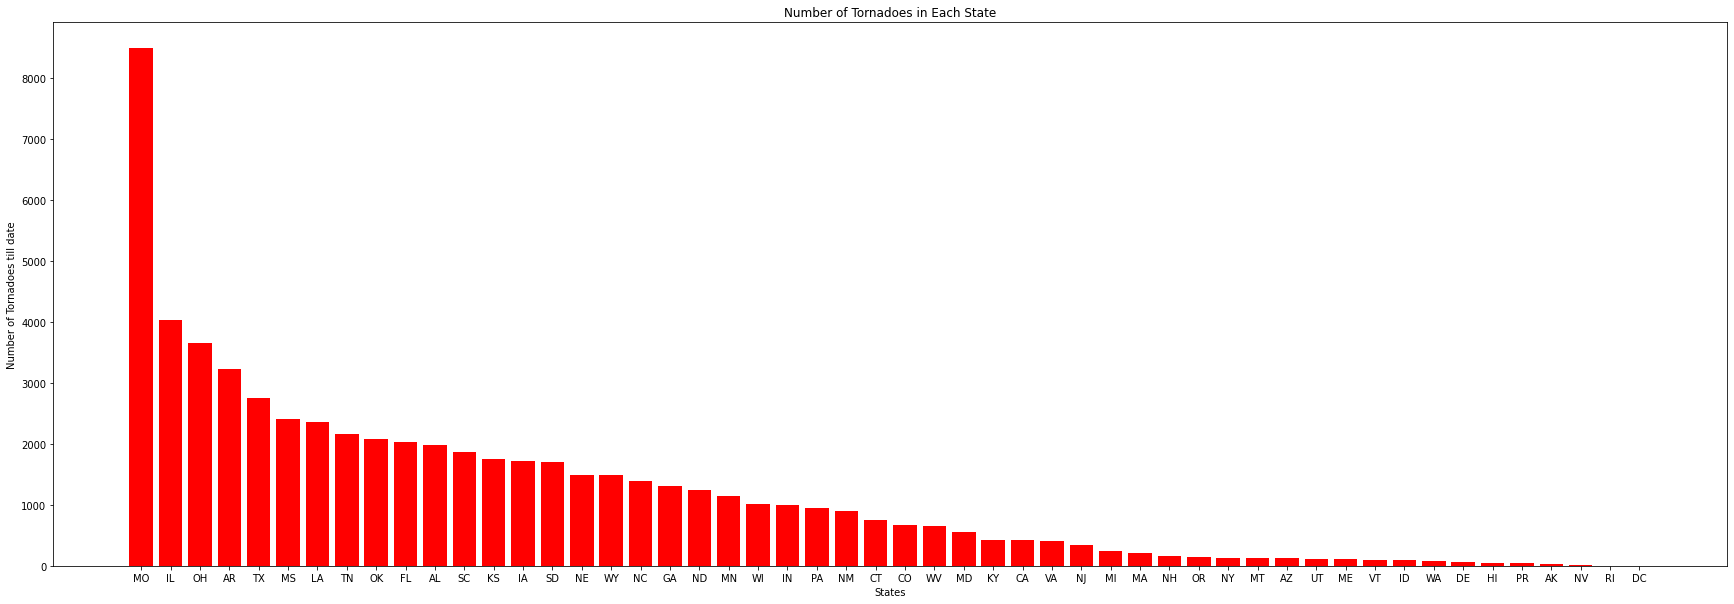

In [43]:
plt.style.use('seaborn-dark-palette')
plt.bar(df['State'].unique(),df['State'].value_counts(),color='r')
plt.xlabel('States')
plt.ylabel('Number of Tornadoes till date')
plt.title('Number of Tornadoes in Each State')
plt.show()

In [48]:
fig = px.histogram(df.sort_values(by=['EF']), x="State", y="EF", color = 'EF', title="Tornado Magnitude over the years", 
                  labels={'EF':'tornado magnitudes'}, height=400)
fig.show()

In [49]:
df1 = df.copy()

In [50]:
df = df.loc[df['State'] == 'IL']

In [52]:
fig = px.bar(df.sort_values(by=['loss_score']), x='Year', y='loss_score')
fig.show()

# **Predict the Tornado Magnitude**

In [54]:
df1['EF'].unique()

array([3, 1, 2, 4, 0, 5])

## Pre-processing the data for modeling

In [55]:
y1=df1['EF']
X1=df1.drop(['EF', 'date', 'State'],axis=1)

X1_train,X1_test,y1_train,y1_test=train_test_split(X1,y1,train_size=0.7,shuffle=True,random_state=1)

scaler = StandardScaler()
scaler.fit(X1_train,X1_test)

X1_train_scaled = pd.DataFrame(scaler.transform(X1_train), index=X1_train.index, columns=X1_train.columns)
X1_test_scaled = pd.DataFrame(scaler.transform(X1_test), index=X1_test.index, columns=X1_test.columns)

## Logistic Regression

In [56]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X1_train_scaled, y1_train)

y1_pred_logreg = LogReg.predict(X1_test_scaled)

confusion_matrix1_s_lr = confusion_matrix(y1_test, y1_pred_logreg)

print(confusion_matrix1_s_lr)
print(classification_report(y1_test, y1_pred_logreg))
print('Train Score: ', LogReg.score(X1_train_scaled, y1_train))  
print('Test Score: ', LogReg.score(X1_test_scaled, y1_test))

logreg_accuracy_s_lr = accuracy_score(y1_test,y1_pred_logreg)*100

print('Accuracy acheived by Logistic Regression:',logreg_accuracy_s_lr)

[[8081  232   10    2    0    0]
 [ 971 4714  398    7    0    0]
 [ 136 1742  831   19    1    0]
 [   6  227  387   59   13    0]
 [   1   14   87   53   27    1]
 [   0    0    1    2    9    4]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      8325
           1       0.68      0.77      0.72      6090
           2       0.48      0.30      0.37      2729
           3       0.42      0.09      0.14       692
           4       0.54      0.15      0.23       183
           5       0.80      0.25      0.38        16

    accuracy                           0.76     18035
   macro avg       0.63      0.42      0.46     18035
weighted avg       0.73      0.76      0.74     18035

Train Score:  0.7597851659972908
Test Score:  0.760521208760743
Accuracy acheived by Logistic Regression: 76.0521208760743


## Decision Tree Classifier

In [57]:
dtc = DecisionTreeClassifier()
dtc = dtc.fit(X1_train_scaled, y1_train)
y1_pred_dtc_ws = dtc.predict(X1_test_scaled)

print('Train Score: ', dtc.score(X1_train_scaled, y1_train))  
print('Test Score: ', dtc.score(X1_test, y1_test))

confusion_matrix1_s_dtc = confusion_matrix(y1_test, y1_pred_dtc_ws)

print(confusion_matrix1_s_dtc)
print(classification_report(y1_test, y1_pred_dtc_ws))

dtc_accuracy = accuracy_score(y1_test,y1_pred_dtc_ws)*100

print("Accuracy acheived by decision tree classifier:",dtc_accuracy)

Train Score:  0.999952470353383
Test Score:  0.03182700304962573
[[7679  589   50    7    0    0]
 [ 579 4084 1223  188   14    2]
 [  70 1180 1144  304   30    1]
 [   1  147  270  209   57    8]
 [   1   17   36   68   50   11]
 [   0    0    1    1    9    5]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      8325
           1       0.68      0.67      0.67      6090
           2       0.42      0.42      0.42      2729
           3       0.27      0.30      0.28       692
           4       0.31      0.27      0.29       183
           5       0.19      0.31      0.23        16

    accuracy                           0.73     18035
   macro avg       0.46      0.48      0.47     18035
weighted avg       0.73      0.73      0.73     18035

Accuracy acheived by decision tree classifier: 73.030219018575


## Random Forest Classifier

In [58]:
rfc=RandomForestClassifier(n_estimators=150,max_features=5)
rfc.fit(X1_train_scaled,y1_train)
y1_pred_rfc=rfc.predict(X1_test_scaled)
rfc_result1 = confusion_matrix(y1_test, y1_pred_rfc)

print("Confusion Matrix:")
print(rfc_result1)

result_rfc1 = classification_report(y1_test, y1_pred_rfc)
print("Classification Report:",)
print (result_rfc1)

rfc_accuracy1 = accuracy_score(y1_test,y1_pred_rfc)
print("Accuracy by random forest classifier:",rfc_accuracy1*100)

Confusion Matrix:
[[7958  361    6    0    0    0]
 [ 502 4915  650   22    1    0]
 [  37 1295 1279  111    7    0]
 [   0  118  341  210   23    0]
 [   1    8   36   87   51    0]
 [   0    0    0    4   11    1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8325
           1       0.73      0.81      0.77      6090
           2       0.55      0.47      0.51      2729
           3       0.48      0.30      0.37       692
           4       0.55      0.28      0.37       183
           5       1.00      0.06      0.12        16

    accuracy                           0.80     18035
   macro avg       0.71      0.48      0.51     18035
weighted avg       0.79      0.80      0.79     18035

Accuracy by random forest classifier: 79.92237316329359


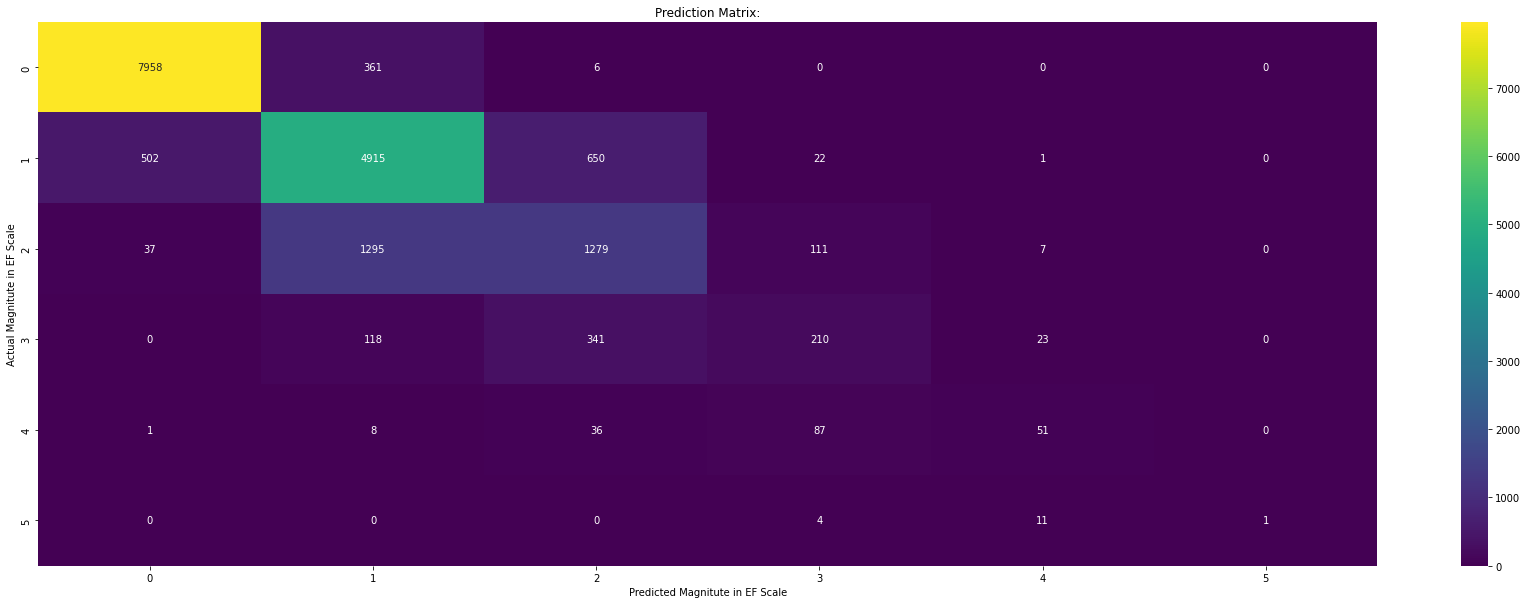

In [59]:
sns.heatmap(rfc_result1 ,annot=True,fmt="d",cmap='viridis')
plt.title('Prediction Matrix:')
plt.ylabel('Actual Magnitute in EF Scale')
plt.xlabel('Predicted Magnitute in EF Scale')
plt.show()